<a href="https://colab.research.google.com/github/bbmt/BSP_Reader/blob/main/FPA_ReaderBSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Script for extracting images FPA BSP Agilent files
Imbuia Beamline@LNLS

**This script works for FPA bsp files. This is not for multispectra, pontual files.**

**This is script was not tested for MOSAIC files.**

**Plese name your file without whitespaces.**

For processing the file, hit **Crtl-F9** (or Command-F9 if you are using Mac). The script will extract all relevant data from the BSP file. The only required user action is in the *Upload file* cell.

*If any error occurs, please send a printscreen and the bsp file to bruno.torres@lnls.br or brunobassi@ifsc.usp.br.*

In [1]:
#@title Install and Import
#Install and Import
!pip install olefile

import sys
import os
from google.colab import files
import array
import olefile
import re
import csv
import struct

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 1.1 MB/s eta 0:00:00


In [ ]:
#@title Upload file - **ACTION REQUIRED**
#@markdown Press the button to open a dialog to choose the file to be processed.
#@markdown **Only one file.**
uploaded = files.upload()

Saving testebsp.bsp to testebsp.bsp


In [ ]:
#@title Folder Structure
filename = uploaded[list(uploaded.keys())[0]]
path_to_save = '/content/'+ list(uploaded.keys())[0][:-4]
os.makedirs(path_to_save+'/Images',exist_ok=True)
os.makedirs(path_to_save+'/TempBin',exist_ok=True)

In [ ]:
#@title Processing data streams
if olefile.isOleFile(filename):
    with olefile.OleFileIO(filename) as ole:
        streams = ole.listdir(storages=False, streams=True)

        streams_list = ole.openstream(['Spectra','IndexTable']).read()

        streams_list = re.findall(b'(\w{8}-\w{8})',streams_list)

#  with olefile.OleFileIO(filename) as ole:
        stream_data = []
        for stream_ in streams_list:
            stream_data.append(ole.openstream(['Spectra',stream_.decode()]).read())

for name,data in zip(streams_list,stream_data):
    with open(path_to_save+'/TempBin/'+name.decode()+'.bin','wb+') as f:
        f.write(data)

In [ ]:
#@title Extracting images
def extract_jpg_image(stream_name):
    jpg_byte_start = b'\xff\xd8\xff\xe0'
    jpg_byte_end = b'\xff\xd9'
    jpg_image = bytearray()

    with open(path_to_save+'/TempBin/'+stream_name.decode()+'.bin', 'rb') as f:
        full_extracted_data = f.read()

        startimg = full_extracted_data.find(jpg_byte_start)
        sample_name = re.findall(b'(?:\x00SpectName)(?:.{11})(?:\x00PropType\x01)(?:.{19})(?:\x31\x2e\x30\x30)(?:\W{20})(.+)(?:.{4})(?:\x53\x70)',full_extracted_data)[0].decode()

        if startimg == -1:
            print('!Warning!Could not find a valid JPEG image in the data stream:'+stream_name.decode())
            print('It is ok if you did not take a visible image for this experiment.')
            return

        else:
            print('Image found:'+stream_name.decode()+' Saving...\n')
            endimg = full_extracted_data.find(jpg_byte_end, startimg) + len(jpg_byte_end)
            jpg_image += full_extracted_data[startimg:endimg]

            with open(path_to_save+'/Images/'+stream_name.decode()+'_'+sample_name+'.jpg', 'wb+') as f:
                f.write(jpg_image)

for stream_name in streams_list:
    extract_jpg_image(stream_name)

!Could not find a valid JPEG image in the data stream:
000492F7-632C5AC6
Probably there is only one image in the bsp file.

!Could not find a valid JPEG image in the data stream:
000492F5-632C59F2
Probably there is only one image in the bsp file.

!Could not find a valid JPEG image in the data stream:
000492F3-632C592F
Probably there is only one image in the bsp file.

Image found:000492F1-632C587D Saving...



In [ ]:
#@title Cleaning up and saving files to zip...
#@markdown The files will be downloaded by the browser

for temp_bin in os.listdir(path_to_save+'/TempBin/'):
    os.unlink(path_to_save+'/TempBin/'+temp_bin)

os.rmdir(path_to_save+'/TempBin')

to_zip = "/content/"+list(uploaded.keys())[0][:-4]
zip_file = "/content/all_data_"+list(uploaded.keys())[0][:-4]+".zip"
!zip -r -9 {zip_file} {to_zip}

files.download(zip_file)

for root, dirs, files in os.walk(path_to_save, topdown=False):
    for name in files:
        os.remove(os.path.join(root, name))
    for name in dirs:
        os.rmdir(os.path.join(root, name))
os.rmdir(path_to_save)
os.remove(list(uploaded.keys())[0])

  adding: content/multi-spectral/ (stored 0%)
  adding: content/multi-spectral/Interferogram/ (stored 0%)
  adding: content/multi-spectral/Interferogram/000492F3-632C592F_sample(2)_interferogram.csv (deflated 58%)
  adding: content/multi-spectral/Interferogram/000492F1-632C587D_background_interferogram.csv (deflated 58%)
  adding: content/multi-spectral/Interferogram/000492F5-632C59F2_sample(3)_interferogram.csv (deflated 58%)
  adding: content/multi-spectral/Interferogram/000492F7-632C5AC6_sample(4)_interferogram.csv (deflated 58%)
  adding: content/multi-spectral/Images/ (stored 0%)
  adding: content/multi-spectral/Images/000492F1-632C587D.jpg (deflated 77%)
  adding: content/multi-spectral/Spectra/ (stored 0%)
  adding: content/multi-spectral/Spectra/000492F7-632C5AC6_sample(4)_spectrum.csv (deflated 52%)
  adding: content/multi-spectral/Spectra/000492F3-632C592F_sample(2)_spectrum.csv (deflated 51%)
  adding: content/multi-spectral/Spectra/000492F5-632C59F2_sample(3)_spectrum.csv (

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

*If the browser does not automatically download the zip files, you can open the **folder tab** and download from there. (As shown in the image)*

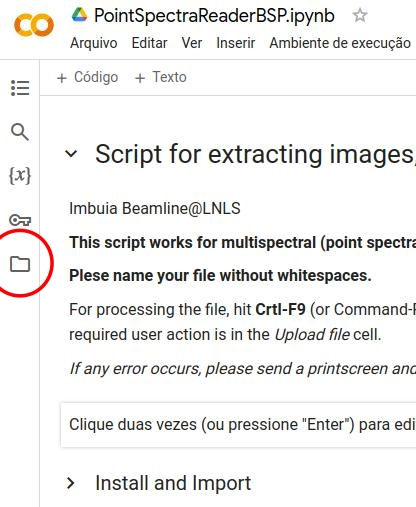